## Inspect a model topography

In [18]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
print("Last updated:",time.strftime("%c"))

date: Wed May 13 12:08:05 2020


In [2]:
targ_topo =  netCDF4.Dataset('/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing_GB2020/topog_merged.nc')
targ_havg = np.array(targ_topo.variables['height'])
targ_hmin = np.array(targ_topo.variables['h_min'])
targ_hmax = np.array(targ_topo.variables['h_max'])
targ_wet=np.zeros(targ_havg.shape)
targ_wet=np.where(targ_havg<0.,1.0,0.0)

#### Get longitude,latitude from grid
##### This can easily be included in the model topography file. Why isn't it?

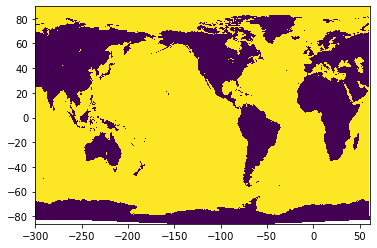

In [3]:
targ_grid =  netCDF4.Dataset('/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing_GB2020/ocean_hgrid.nc')
targ_x = np.array(targ_grid.variables['x'])[::2,::2]
targ_y = np.array(targ_grid.variables['y'])[::2,::2]
plt.pcolormesh(targ_x,targ_y,targ_wet);

### Use ice9 algorithm to produce wet mask

In [4]:
def ice9it(i,j,depth):
  # Iterative implementation of "ice 9"
  wetMask = 0*depth
  (nj,ni) = wetMask.shape
  stack = set()
  stack.add( (j,i) )
  while stack:
    (j,i) = stack.pop()
    if wetMask[j,i] or depth[j,i] >= 0: continue
    wetMask[j,i] = 1
    if i>0: stack.add( (j,i-1) )
    else: stack.add( (j,ni-1) )
    if i<ni-1: stack.add( (j,i+1) )
    else: stack.add( (0,j) )
    if j>0: stack.add( (j-1,i) )
    if j<nj-1: stack.add( (j+1,i) )
    else: stack.add( (j,ni-1-i) )
  return wetMask

#### Note Black Sea is missing when we use  h_avg to produce wet mask 

In [5]:
iseed,jseed = 10,1000 #indices of any point that you know should be wet 
ice9_wetavg = ice9it(iseed,jseed,targ_havg)

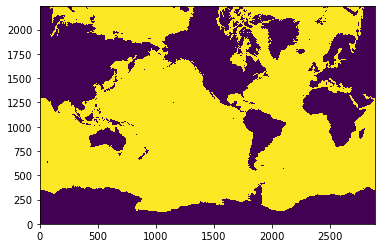

In [6]:
plt.pcolormesh(ice9_wetavg);

#### Note Black Sea appears when we instead use  h_min to produce wet mask 

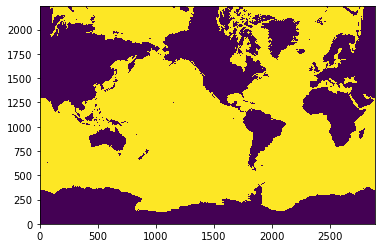

In [7]:
ice9_wet_min = ice9it(iseed,jseed,targ_hmin)
plt.pcolormesh(ice9_wet_min);

### Zoom in on a region

wanted:  28.03 41.04
got:     11.5 41.02706492342095
1454 2492


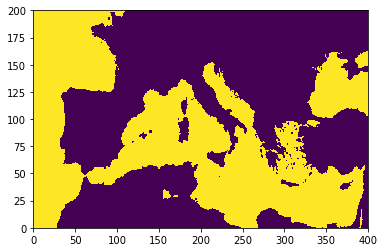

In [31]:
def get_indices(lon_grid,lat_grid,x,y):
    """This function returns the j,i indices for the grid point closest to the input lon,lat coordinates."""
    """It returns the j,i indices."""
    lons=np.fabs(lon_grid-x)
    lonm=np.where(lons==lons.min())
    lats=np.fabs(lat_grid-y)
    latm=np.where(lats==lats.min())
    j0=latm[0][0]
    i0=lonm[1][0]
    print("wanted: ",x,y)
    print("got:    ",lon_grid[j0,i0] , lat_grid[j0,i0])
    print(j0,i0)
    return j0,i0

#Zoom in on Black Sea channel
#j0,i0=get_indices(targ_x, targ_y ,29.03, 41.04)
j0,i0=get_indices(targ_x, targ_y ,28.03, 41.04)
di0,dj0=200,100
im,ip = i0-di0, i0+di0
jm,jp = j0-dj0, j0+dj0
plt.pcolormesh(targ_wet[jm:jp,im:ip]);

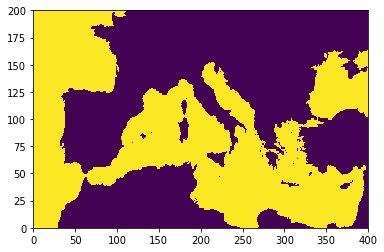

In [32]:
plt.pcolormesh(ice9_wet_min[jm:jp,im:ip]);

#### As you see above, if we sample the "minimum" depth rather than "average" when we coarse-grain the Bosphorus and Dardanelles open up and the Gibraltar widens.

### Plot  the wetmask on the grid mesh
#### As you see the grid has a displaced southern cap

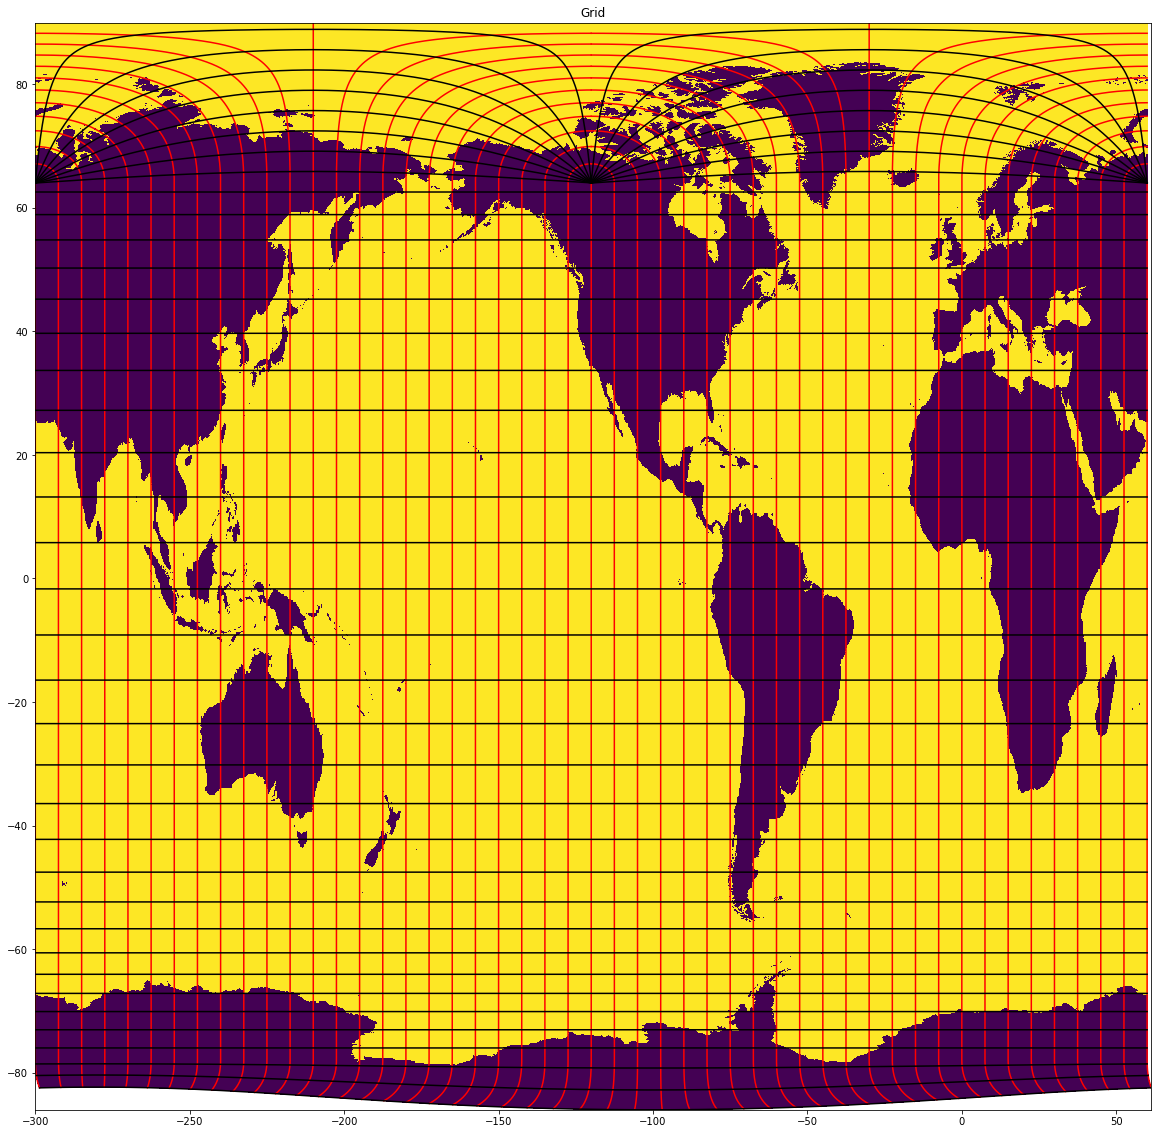

In [14]:
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r'):
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)

plt.figure(figsize=(20,20))
plt.title("Grid")
plot_mesh_in_latlon(targ_x,targ_y, stride=60)
plt.pcolormesh(targ_x,targ_y,ice9_wet_min);